# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Regression Modeling to Forecast Bike Sharing Usage



**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Chris Tanner

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [6pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

**1.1 Load the dataset from the csv file...**

In [3]:
bikes_df_raw = pd.read_csv('data/BSS_hour_raw.csv')
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [4]:
print(bikes_df_raw.describe())
print(bikes_df_raw.dtypes)
print("Season set of values: {}".format(set(bikes_df_raw.season)))
print("Hour set of values: {}".format(set(bikes_df_raw.hour)))
print("Weekday set of values: {}".format(set(bikes_df_raw.weekday)))
print("Holiday set of values: {}".format(set(bikes_df_raw.holiday)))
print("Weather set of values: {}".format(set(bikes_df_raw.weather)))
bikes_df_raw.isnull().sum()

             season          hour       holiday       weekday    workingday  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       2.501640     11.546752      0.028770      3.003683      0.682721   
std        1.106918      6.914405      0.167165      2.005771      0.465431   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      6.000000      0.000000      1.000000      0.000000   
50%        3.000000     12.000000      0.000000      3.000000      1.000000   
75%        3.000000     18.000000      0.000000      5.000000      1.000000   
max        4.000000     23.000000      1.000000      6.000000      1.000000   

            weather          temp         atemp           hum     windspeed  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       1.425283      0.496987      0.475775      0.627229      0.190098   
std        0.639357      0.192556      0.171850    

dteday        0
season        0
hour          0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
dtype: int64

- The type of dteday is **object**, so we need to change it to another more useful type
- Weather related variables like temp and atemp, hum and windspeed (all type float) are normalized to between 0 and 1.
- I can't notice anything strange in the rest of the variables. Ranges and values seem normal.
- There are no NAN or missing values.

**1.2 Notice that the variable in column...**

dteday is type **object**

In [5]:
bikes_df_raw.dteday = pd.to_datetime(bikes_df_raw.dteday)
print(bikes_df_raw.dteday.dtype)

datetime64[ns]


**1.3 Create three new columns in the dataframe:...**

In [6]:
bikes_df_raw.insert(1,'year', [date.year%2011 for date in bikes_df_raw.dteday])
bikes_df_raw.insert(2,'month', [date.month for date in bikes_df_raw.dteday])
bikes_df_raw.insert(3,'day', [date.day for date in bikes_df_raw.dteday])
bikes_df_raw.head()

,dteday,year,month,day,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,0,1,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,0,1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,0,1,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,0,1,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,0,1,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


---

<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`

**2.7** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.8** Use the one-hot-encoded `weather` related variables to show how each weather category affects the relationships in question 2.6.  Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

### Answers

**2.1 Make a new dataframe...**

In [7]:
bikes_by_day = bikes_df_raw.groupby('dteday').agg({'weekday':np.mean, 
                                                   'weather': np.max,
                                                   'season': np.mean,
                                                   'temp': np.mean, 
                                                   'atemp': np.mean, 
                                                   'windspeed': np.mean, 
                                                   'hum': np.mean, 
                                                   'casual': np.sum,
                                                   'registered': np.sum})
bikes_by_day['counts'] = bikes_by_day.casual + bikes_by_day.registered

bikes_by_day.head()

,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,
2011-01-01,6,3,1,0.344167,0.363625,0.160446,0.805833,331,654,985
2011-01-02,0,3,1,0.363478,0.353739,0.248539,0.696087,131,670,801
2011-01-03,1,1,1,0.196364,0.189405,0.248309,0.437273,120,1229,1349
2011-01-04,2,2,1,0.200000,0.212122,0.160296,0.590435,108,1454,1562
2011-01-05,3,1,1,0.226957,0.229270,0.186900,0.436957,82,1518,1600


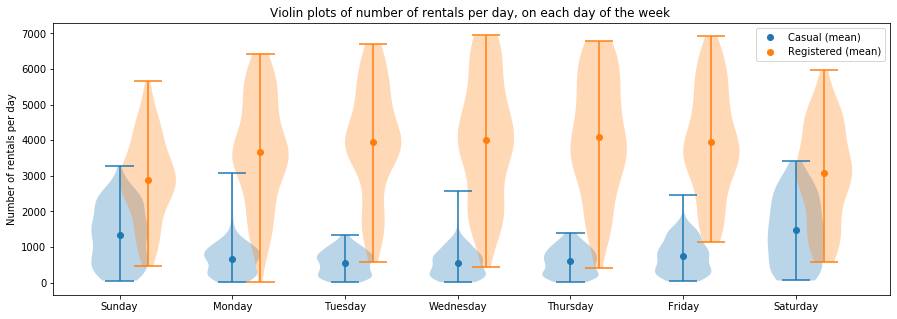

In [8]:
casual_list = [bikes_by_day.casual[bikes_by_day.weekday == i] for i in range(7)]
casual_means = [np.array(cas).mean() for cas in casual_list]
registered_list = [bikes_by_day.registered[bikes_by_day.weekday == i] for i in range(7)]
registered_means = [np.array(reg).mean() for reg in registered_list]

plt.figure(figsize=(15,5))
plt.xticks(range(7),['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
plt.ylabel('Number of rentals per day')
plt.title('Violin plots of number of rentals per day, on each day of the week ')
plt.violinplot(casual_list, positions = np.arange(7))
plt.violinplot(registered_list, positions = np.arange(7)+0.25)
plt.scatter(range(7), casual_means, label = "Casual (mean)")
plt.scatter(np.arange(7)+0.25, registered_means, label = "Registered (mean)")
plt.legend();

**2.2 Use `bikes_by_day` to visualize how the distribution...**

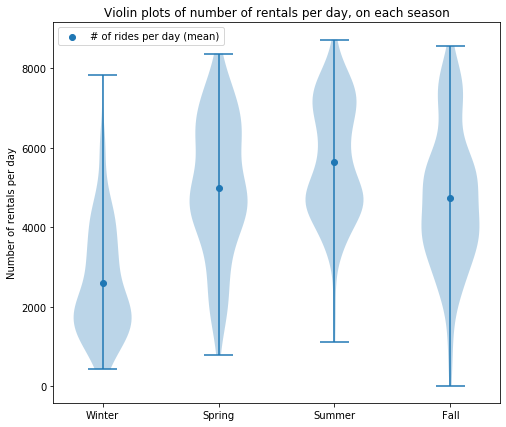

In [9]:
season_list = [bikes_by_day.counts[bikes_by_day.season == i] for i in range(1,5)]
season_means = [np.array(seas).mean() for seas in season_list]
seasons = ['Winter','Spring','Summer','Fall']

plt.figure(figsize=(8,7))
plt.xticks(range(4),['Winter','Spring','Summer','Fall'])
plt.ylabel('Number of rentals per day')
plt.title('Violin plots of number of rentals per day, on each season')
plt.violinplot(season_list, positions = np.arange(4))
plt.scatter(range(4), season_means, label = "# of rides per day (mean)")
plt.legend(loc='upper left');



Outliers in Winter, 1 found: [7836]
Outliers in Spring, 0 found: []
Outliers in Summer, 0 found: []
Outliers in Fall, 1 found: [22]


,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,
2012-03-17,6,2,1,0.514167,0.505046,0.110704,0.755833,3155,4681,7836
2012-10-29,1,3,4,0.440000,0.439400,0.358200,0.880000,2,20,22


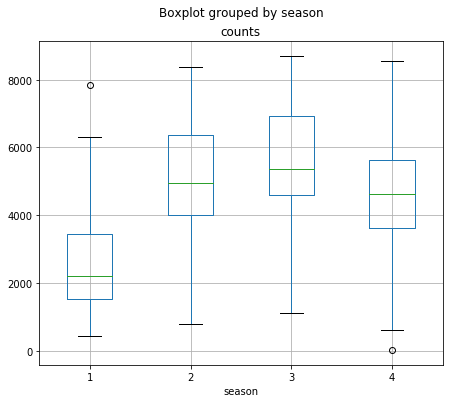

In [10]:
bp = bikes_by_day.boxplot('counts',by='season', return_type = 'dict', figsize = (7,6));
season_df = pd.DataFrame()
for i in range(4):
    #Pulling out outliers directly from boxplot
    outliers = bp['counts']['fliers'][i].get_ydata()
    print("Outliers in {}, {} found: {}".format(seasons[i], len(outliers), outliers))
    if len(outliers) > 0:
        season_df = season_df.append(bikes_by_day[bikes_by_day.counts.isin(outliers)])

season_df

- Demand for bikes is seasonal, with a low in the Winter and a peak in the Summer.
- March 17, 2012 is St. Patricks Day, so can justify high demand that day
- October 29, 2012 was Hurricane Sandy, so can justify very low demand

**2.3 Convert the categorical attributes...**

In [11]:
bikes_df = bikes_df_raw.copy(deep=True)

In [12]:
categorical = ['season', 'month', 'weekday', 'weather' ]
bikes_df = pd.get_dummies(bikes_df_raw, columns = categorical, drop_first=True)

bikes_df.columns

Index(['dteday', 'year', 'day', 'hour', 'holiday', 'workingday', 'temp',
       'atemp', 'hum', 'windspeed', 'casual', 'registered', 'season_2',
       'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

In [13]:
season_dict = {'season_2': 'spring', 'season_3': 'summer', 'season_4': 'fall'}
month_dict = {'month_2': 'Feb', 'month_3': 'Mar', 'month_4': 'Apr', 'month_5':'May', 'month_6': 'Jun',
          'month_7': 'Jul', 'month_8': 'Aug', 'month_9': 'Sep', 'month_10': 'Oct', 'month_11': 'Nov', 'month_12': 'Dec'}
weekday_dict = {'weekday_1': 'Mon', 'weekday_2': 'Tue', 'weekday_3': 'Wed',
            'weekday_4': 'Thu', 'weekday_5': 'Fri', 'weekday_6': 'Sat'}
weather_dict = {'weather_2': 'Cloudy', 'weather_3': 'Snow', 'weather_4': 'Storm'}
cat_dict = {**season_dict, **month_dict, **weekday_dict, **weather_dict}

bikes_df = bikes_df.rename(columns = cat_dict)
bikes_df.columns

Index(['dteday', 'year', 'day', 'hour', 'holiday', 'workingday', 'temp',
       'atemp', 'hum', 'windspeed', 'casual', 'registered', 'spring', 'summer',
       'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy',
       'Snow', 'Storm'],
      dtype='object')

In [14]:
bikes_df.head()

,dteday,year,day,hour,holiday,workingday,temp,atemp,hum,windspeed,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,2011-01-01,0,1,0,0,0,0.24,0.2879,0.81,0.0,...,0,0,0,0,0,0,1,0,0,0
1,2011-01-01,0,1,1,0,0,0.22,0.2727,0.80,0.0,...,0,0,0,0,0,0,1,0,0,0
2,2011-01-01,0,1,2,0,0,0.22,0.2727,0.80,0.0,...,0,0,0,0,0,0,1,0,0,0
3,2011-01-01,0,1,3,0,0,0.24,0.2879,0.75,0.0,...,0,0,0,0,0,0,1,0,0,0
4,2011-01-01,0,1,4,0,0,0.24,0.2879,0.75,0.0,...,0,0,0,0,0,0,1,0,0,0


**2.4 Split the updated `bikes_df` dataset into a 50-50 train-test split...** 

In [15]:
train_data, test_data = train_test_split(bikes_df, test_size=0.5, random_state=90, stratify=bikes_df_raw['month'])
train_data.head()

,dteday,year,day,hour,holiday,workingday,temp,atemp,hum,windspeed,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
17280,2012-12-27,1,27,21,0,1,0.24,0.2273,0.60,0.2537,...,1,0,0,0,1,0,0,1,0,0
6747,2011-10-13,0,13,17,0,1,0.62,0.5758,0.83,0.2537,...,0,0,0,0,1,0,0,0,1,0
13948,2012-08-09,1,9,9,0,1,0.76,0.7273,0.66,0.1642,...,0,0,0,0,1,0,0,0,0,0
11005,2012-04-08,1,8,17,0,0,0.62,0.6061,0.22,0.2985,...,0,0,0,0,0,0,0,0,0,0
9322,2012-01-29,1,29,8,0,0,0.18,0.1970,0.40,0.1343,...,0,0,0,0,0,0,0,0,0,0


**2.5 Although we asked you to create your train and test set...**

In [16]:
BSS_train = pd.read_csv('data/BSS_test.csv').drop('dteday',axis=1)
BSS_test = pd.read_csv('data/BSS_train.csv').drop('dteday',axis=1)
BSS_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,registered,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,5,0,1,0,0.26,0.2273,0.48,0.2985,0,2,...,1,0,0,0,0,0,0,1,0,0
1,19,0,1,0,0.36,0.3485,0.71,0.1343,29,110,...,0,0,0,0,0,0,1,0,1,0
2,12,0,1,1,0.36,0.3182,0.53,0.4478,13,213,...,1,0,1,0,0,0,0,1,0,0
3,0,0,1,1,0.28,0.3030,0.65,0.0896,4,39,...,0,0,0,0,0,1,0,1,0,0
4,1,0,1,0,0.60,0.5455,0.88,0.1642,31,99,...,0,0,0,0,0,0,0,1,0,0


**2.6 Use pandas' `scatter_matrix` command to visualize...**

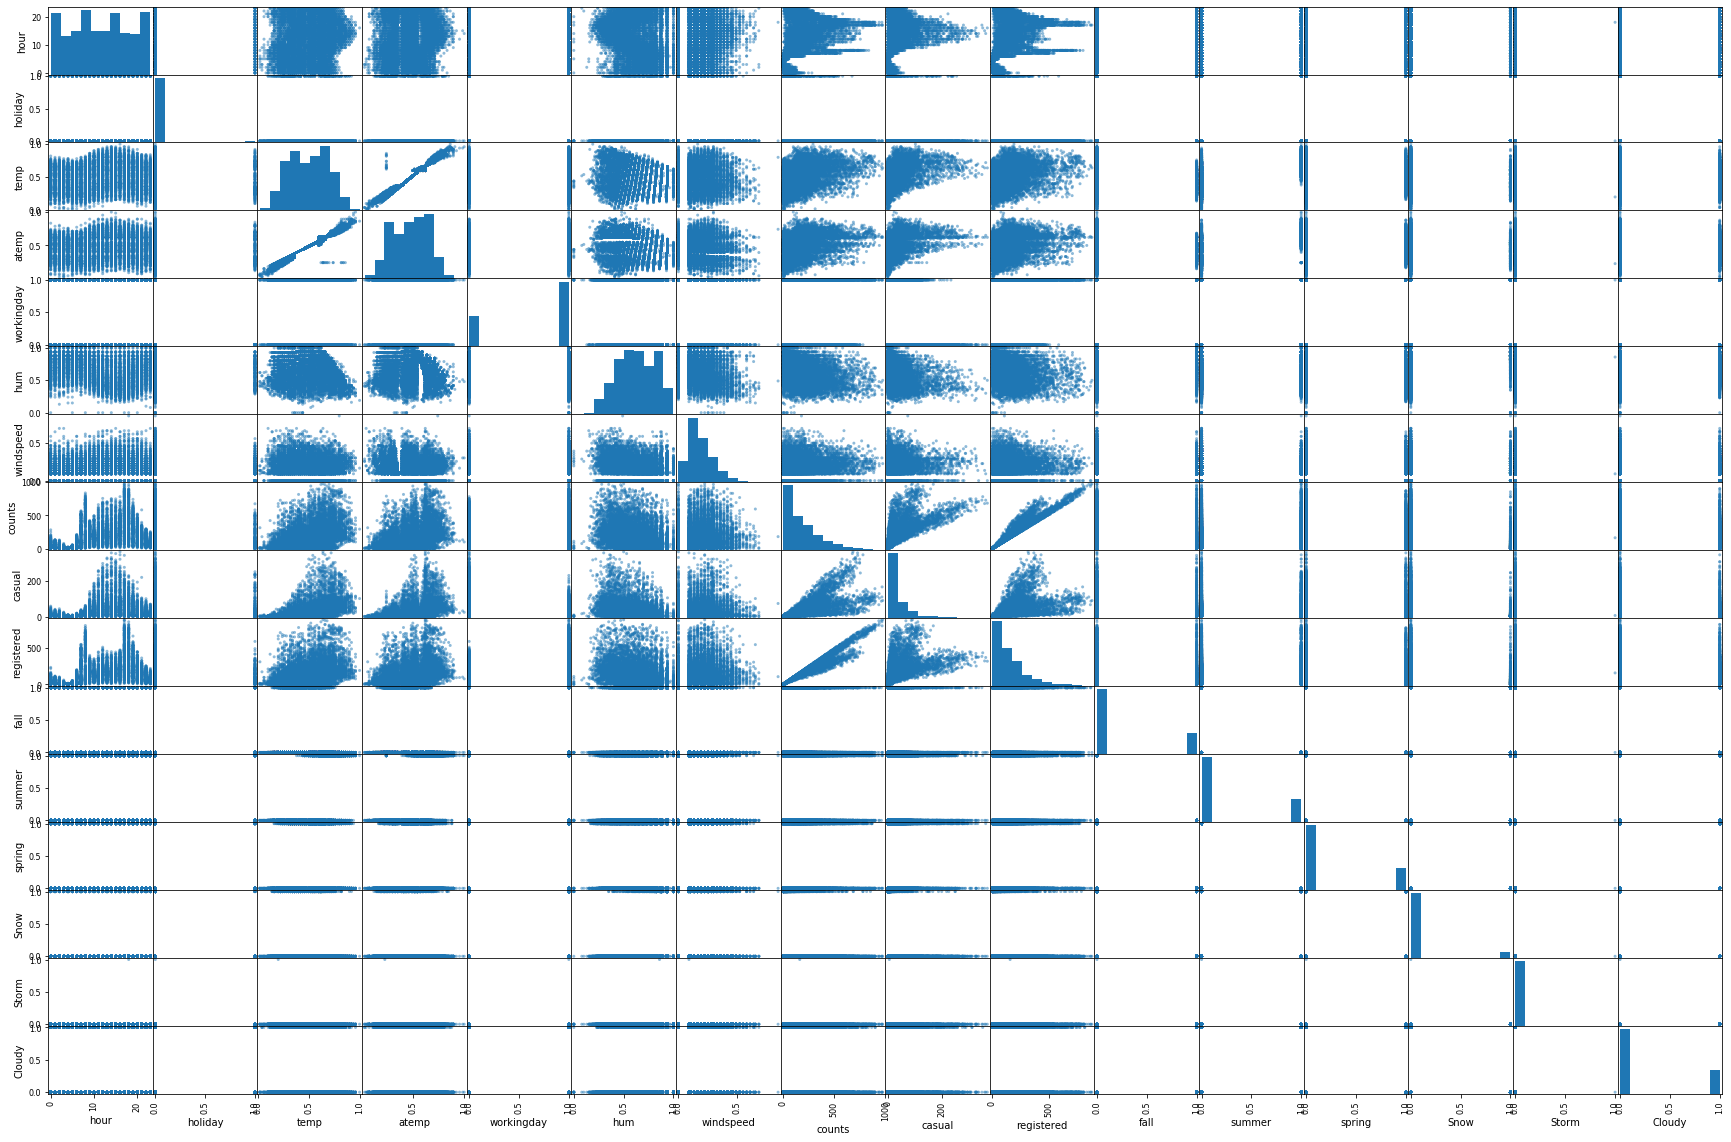

In [17]:
cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']
scatter_matrix(BSS_train[cor_columns], figsize =(30,20));

The clearest relations I see are:
- temp with atemp 
- casual, registered and counts between each other

Not as clear but still a patern:
- temp and atemp with casual, registered and counts

**2.7 Make a plot showing the _average_ number of casual and registered riders...**

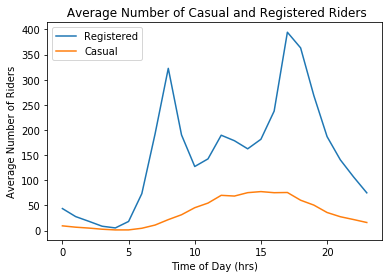

In [18]:
avg_data = BSS_train.groupby('hour').aggregate({'casual': np.mean, 'registered': np.mean})
 
plt.plot(range(avg_data.shape[0]), avg_data['registered'], label="Registered")
plt.plot(range(avg_data.shape[0]), avg_data['casual'], label="Casual")
plt.xlabel("Time of Day (hrs)")
plt.ylabel("Average Number of Riders")
plt.title(" Average Number of Casual and Registered Riders")
plt.legend();

- Registered biker demand peaks around 8am, another peak around 5pm (so work related demand), and is close to 0 before sunrise. I'd assume from this pattern that people who use their bikes to go for work tend to register.
- Casual rider demand is the highest between 10am and 6pm, so its probably more linked to tourists and people biking for fun.

**2.8 Use the weather related variables to show how each weather...** 

In [19]:
BSS_train[BSS_train['Storm'] == 1]

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,registered,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
1614,18,0,1,1,0.2,0.2273,0.86,0.0896,6,158,...,0,1,0,0,0,0,0,0,0,1


There is only one sample in the training set that is classified as "Storm"

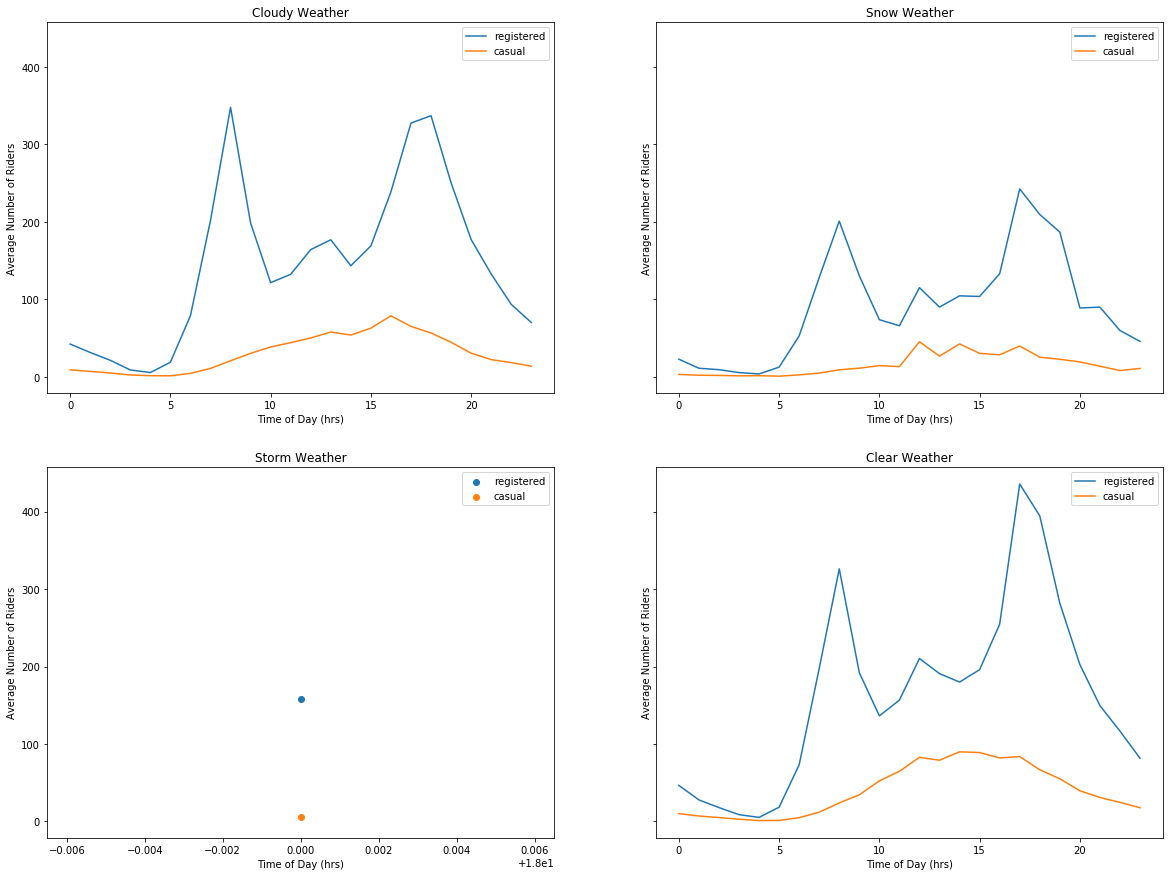

In [20]:
weather_names = ["Cloudy", "Snow", "Storm", "Clear"]

fig, ax = plt.subplots(2,2, figsize=(20,15), sharey=True)

for i in range(0,4):
    if i <= 1:
        sub_ax = ax[0][i]
    else:
        sub_ax = ax[1][i-2]
    if weather_names[i] == "Clear":
        weather_train = BSS_train[(BSS_train[weather_names[0]] + BSS_train[weather_names[1]] 
                                      + BSS_train[weather_names[2]]) == 0]    
        
    else:
        weather_train = BSS_train[BSS_train[weather_names[i]] == 1]
           
    if weather_names[i] == "Storm":
        reg = sub_ax.scatter(weather_train['hour'].values, weather_train['registered'].values, label="registered")
        cas = sub_ax.scatter(weather_train['hour'].values, weather_train['casual'].values, label="casual")
    else:
        avg_data = weather_train.groupby('hour').agg({'casual': np.mean, 'registered': np.mean})    
        sub_ax.plot(avg_data['registered'], label="registered")
        sub_ax.plot(avg_data['casual'], label="casual")
    
    sub_ax.set_ylabel('Average Number of Riders')
    sub_ax.set_xlabel('Time of Day (hrs)')
    sub_ax.set_title('{} Weather'.format(weather_names[i]))
    sub_ax.legend()

- The average number of riders seems to be higher on clear and cloudy weather, somewhat less (a bit over half of the other two) on Snow weather, and almost null on torm weather. Casual rents almost flatline on snowy days. 
- The intraday patterns are very similar for all weather types (except Storm). Casual demand almost flatlines (though not quite) in Snow weather.

---

<div class='exercise'> <b> Question 3 [18pts]: Multiple Linear Regression to Predict Hourly Ridership </b> </div>


**3.1** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

**3.3** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**3.5** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**3.6** You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.



### Answers

**3.1 Use statsmodels to fit a multiple linear regression model...**

In [21]:
BSS_train.columns

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'counts', 'spring', 'summer',
       'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy',
       'Snow', 'Storm'],
      dtype='object')

In [22]:
X_train = sm.add_constant(BSS_train.drop(['counts','casual','registered'], axis=1))
y_train = BSS_train['counts'].values.reshape(-1,1)

model = OLS(y_train, X_train)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     195.8
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        19:23:33   Log-Likelihood:                -55272.
No. Observations:                8690   AIC:                         1.106e+05
Df Residuals:                    8659   BIC:                         1.108e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.3228     11.064     -1.746      0.081     -41.011       2.366
hour           7.2756      0.238     30.559      0.000       6.809       7.742
holiday      -22.5919      8.546     -2.644      0.008     -39.344      -5.840
year          78.5998      3.040     25.856      0.000      72.641      84.559
workingday    10.7803      3.513      3.069      0.002       3.894      17.667
temp         315.5393     53.271      5.923      0.000     211.115     419.963
atemp         86.5838     55.446      1.562      0.118     -22.104     195.271
hum         -204.3296      9.941    -20.554      0.000    -223.817    -184.842
windspeed     32.4178     13.767      2.355      0.019       5.431      59.404
spring        38.9037      9.375      4.150      0.000      20.526      57.282
summer        26.0261     11.229      2.318      0.020       4.014      48.038
fall          61.9885      9.541      6.497      0.000      43.287      80.690
Feb           -8.5333      7.628     -1.119      0.263     -23.487       6.420
Mar          -20.2865      8.615     -2.355      0.019     -37.175      -3.398
Apr          -41.8463     12.592     -3.323      0.001     -66.529     -17.164
May          -21.7075     13.414     -1.618      0.106     -48.003       4.588
Jun          -72.1008     13.669     -5.275      0.000     -98.896     -45.306
Jul          -89.9344     15.458     -5.818      0.000    -120.237     -59.632
Aug          -56.7855     15.144     -3.750      0.000     -86.471     -27.100
Sept          -7.9274     13.570     -0.584      0.559     -34.528      18.673
Oct          -12.7256     12.618     -1.009      0.313     -37.460      12.008
Nov          -17.9604     12.185     -1.474      0.141     -41.847       5.926
Dec           -3.5281      9.702     -0.364      0.716     -22.547      15.490
Mon           -3.1561      3.805     -0.829      0.407     -10.616       4.303
Tue           -8.4242      4.075     -2.067      0.039     -16.413      -0.436
Wed            0.8290      4.087      0.203      0.839      -7.183       8.841
Thu           -3.2258      4.082     -0.790      0.429     -11.227       4.776
Fri            2.1656      4.071      0.532      0.595      -5.815      10.147
Sat           13.7990      5.606      2.461      0.014       2.809      24.789
Cloudy         7.8537      3.699      2.123      0.034       0.603      15.104
Snow         -27.8481      6.261     -4.448      0.000     -40.122     -15.574
Storm         56.1691    140.454      0.400      0.689    -219.154     331.492
==============================================================================
Omnibus:                     1819.337   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3714.302
Skew:                           1.243   Prob(JB):                         0.00
Ku

In [23]:
X_test = sm.add_constant(BSS_test.drop(['counts','casual','registered'], axis=1))
y_test = BSS_test['counts'].values.reshape(-1,1)

y_hat_train = results.predict()
y_hat_test = results.predict(exog=X_test)

print('Train R^2 = {:.4}'.format(results.rsquared))
print('Test R^2 = {:.4}'.format(r2_score(y_test, y_hat_test)))

Train R^2 = 0.4041
Test R^2 = 0.4082


**3.2 Examine the estimated coefficients and report...**

In [24]:
print("Statistically Significant Coefficients (p-value < 0.05)")
signif_df = pd.concat([results.params[results.pvalues < 0.05], results.pvalues[results.pvalues < 0.05]],axis=1)
signif_df.columns = ['Coefficients','P-Values']
signif_df.round(4)

Statistically Significant Coefficients (p-value < 0.05)


,Coefficients,P-Values
hour,7.2756,0.0000
holiday,-22.5919,0.0082
year,78.5998,0.0000
workingday,10.7803,0.0022
temp,315.5393,0.0000
hum,-204.3296,0.0000
windspeed,32.4178,0.0186
spring,38.9037,0.0000
summer,26.0261,0.0205
fall,61.9885,0.0000


In [25]:
print("Non- Statistically Significant Coefficients (p-value >= 0.05)")
non_signif_df = pd.concat([results.params[results.pvalues >= 0.05], results.pvalues[results.pvalues >= 0.05]],axis=1)
non_signif_df.columns = ['Coefficients','P-Values']
non_signif_df.round(4)

Non- Statistically Significant Coefficients (p-value >= 0.05)


,Coefficients,P-Values
const,-19.3228,0.0808
atemp,86.5838,0.1184
Feb,-8.5333,0.2633
May,-21.7075,0.1056
Sept,-7.9274,0.5591
Oct,-12.7256,0.3132
Nov,-17.9604,0.1405
Dec,-3.5281,0.7161
Mon,-3.1561,0.4069
Wed,0.8290,0.8393


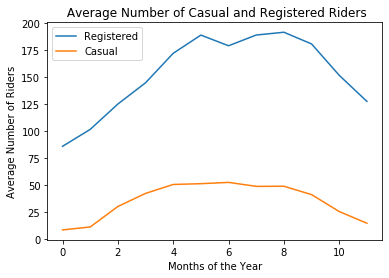

In [26]:
avg_data_month = bikes_df_raw.groupby('month').aggregate({'casual': np.mean, 'registered': np.mean})
 
plt.plot(range(avg_data_month.shape[0]), avg_data_month['registered'], label="Registered")
plt.plot(range(avg_data_month.shape[0]), avg_data_month['casual'], label="Casual")
plt.xlabel("Months of the Year")
plt.ylabel("Average Number of Riders")
plt.title(" Average Number of Casual and Registered Riders")
plt.legend();

In [27]:
X_temp_train = sm.add_constant(BSS_train.drop(['counts','casual','registered','temp','atemp'], axis=1))
y_temp_train = BSS_train['counts'].values.reshape(-1,1)

temp_model = OLS(y_temp_train, X_temp_train)
temp_results = temp_model.fit()
print("Coefficients for summer months with a model removing temp and atemp features")
temp_results.params[['May','Jun','Jul','Aug','Sept']]

Coefficients for summer months with a model removing temp and atemp features


May     121.474725
Jun      94.645192
Jul      88.970761
Aug     103.354915
Sept    123.165408
dtype: float64

**3.3 You should see some strange estimates for the predictors representing months...** 

- We first plot average riders to month, and see that demand for bikes peak around summer. Clearly temp is correlated with month of the year. 
- If we remove the temp and atemp features from the model, we see that coefficients for summer months, turn very positive.
- July in particular sees a slight drop in registered rider demand, compared to adjacent months. This could be caused by vacations decreasing demand for work related rentals, or just multicollinearity effects.
- The main reason we get a negative coefficient for July is multicolinearity with the highly positive and significant **temp** feature, and a second reason is reduced demand for registered bikes in July compared to adjacent months because of vacations

**3.4 To diagnose the model, make two plots:...**

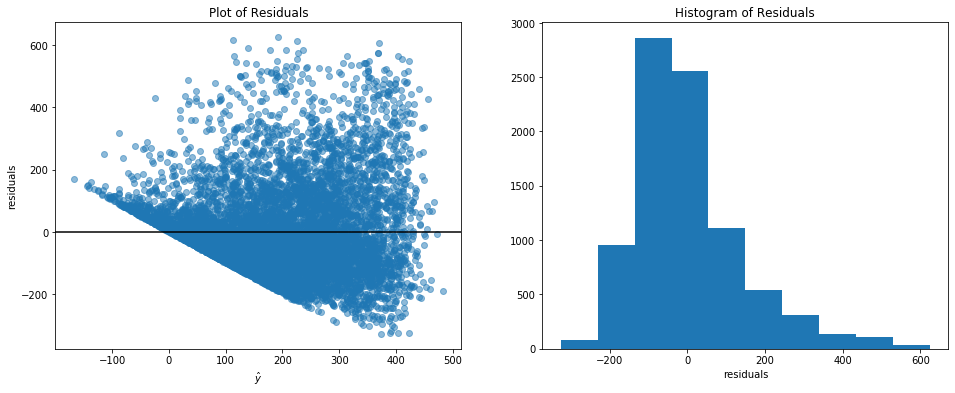

In [28]:
# your code here
residuals = y_train[:,0] - y_hat_train
fig, ax = plt.subplots(1,2,figsize=(16,6))

ax[0].scatter(y_hat_train, residuals, alpha=0.5)
ax[0].set_title('Plot of Residuals')
ax[0].set_xlabel(r'$\hat{y}$')
ax[0].set_ylabel('residuals')
ax[0].axhline(0,c='black')

ax[1].hist(residuals)
ax[1].set_title('Histogram of Residuals')
ax[1].set_xlabel(r'residuals')

plt.show()

- Clearly, the linear model assumptions aren't validated by the data. 
- There is an empty "patch" in the lower left side on the scatter plot, which happens because we can't have a negative number of riders in reality, while the model can take negative values.
- The residuals in the scatterplot from left to right show a conic shape, with variance increasing for larger $\hat{y}$ 
- The histogram shows that the model has a fat right tail. We can see this skew in the data in the scatter plot, too, looking at the residual range.
- It's clear the residuals are not distributed normal.

**3.5 Perhaps we can do better via a model...**

In [29]:
X_train_poly = X_train.copy()
X_train_poly['hour_2'] = X_train_poly.hour**2
X_train_poly['temp_2'] = X_train_poly.temp**2
X_train_poly['hum_2'] = X_train_poly.hum**2

X_test_poly = X_test.copy()
X_test_poly['hour_2'] = X_test_poly.hour**2
X_test_poly['temp_2'] = X_test_poly.temp**2
X_test_poly['hum_2'] = X_test_poly.hum**2

model_poly = OLS(y_train, X_train_poly).fit()
model_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     256.2
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        19:23:34   Log-Likelihood:                -54561.
No. Observations:                8690   AIC:                         1.092e+05
Df Residuals:                    8656   BIC:                         1.094e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -185.6531     18.102    -10.256      0.000    -221.137    -150.169
hour          39.0375      0.848     46.040      0.000      37.375      40.700
holiday      -20.5598      7.882     -2.608      0.009     -36.010      -5.109
year          82.7748      2.821     29.342      0.000      77.245      88.305
workingday    12.2313      3.239      3.777      0.000       5.883      18.580
temp         117.6261     71.723      1.640      0.101     -22.969     258.221
atemp         84.9243     52.316      1.623      0.105     -17.628     187.477
hum            9.4890     46.789      0.203      0.839     -82.229     101.207
windspeed      5.1432     12.753      0.403      0.687     -19.855      30.142
spring        36.9021      8.642      4.270      0.000      19.962      53.842
summer        30.6234     10.375      2.952      0.003      10.286      50.961
fall          62.7945      8.807      7.130      0.000      45.531      80.058
Feb            6.0776      7.128      0.853      0.394      -7.896      20.051
Mar            7.8992      8.205      0.963      0.336      -8.185      23.984
Apr           -3.6372     11.850     -0.307      0.759     -26.867      19.592
May           14.7893     12.531      1.180      0.238      -9.775      39.354
Jun          -21.5032     12.734     -1.689      0.091     -46.466       3.459
Jul          -44.9786     14.361     -3.132      0.002     -73.130     -16.828
Aug          -16.7499     14.113     -1.187      0.235     -44.415      10.916
Sept          23.1264     12.755      1.813      0.070      -1.876      48.129
Oct           15.1658     11.918      1.272      0.203      -8.197      38.528
Nov            0.4488     11.443      0.039      0.969     -21.981      22.879
Dec            6.2025      9.079      0.683      0.495     -11.595      24.000
Mon           -5.8853      3.508     -1.678      0.093     -12.762       0.991
Tue           -6.7002      3.756     -1.784      0.074     -14.063       0.662
Wed            1.2352      3.768      0.328      0.743      -6.151       8.622
Thu           -0.3453      3.763     -0.092      0.927      -7.721       7.030
Fri            3.3670      3.753      0.897      0.370      -3.990      10.724
Sat           12.8392      5.168      2.484      0.013       2.708      22.970
Cloudy        -7.5166      3.436     -2.188      0.029     -14.252      -0.781
Snow         -46.6630      5.965     -7.823      0.000     -58.356     -34.970
Storm         13.5571    129.454      0.105      0.917    -240.203     267.317
hour_2        -1.3322      0.034    -38.798      0.000      -1.400      -1.265
temp_2       103.2545     46.590      2.216      0.027      11.928     194.581
hum_2       -107.6723     37.328     -2.885      0.004    -180.843     -34.502
==============================================================================
Om

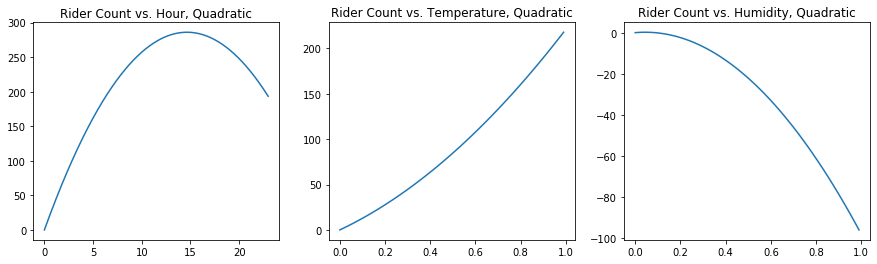

In [30]:
def poly_2_print(ax, x, coef, string):
    ax.plot(x, coef[0]*x +coef[1]*(x**2))
    ax.set_title("Rider Count vs. {}, Quadratic".format(string))
    return ax

hour_coef = model_poly.params[['hour','hour_2']]
hour_x = np.arange(0,23,0.01)

temp_coef = model_poly.params[['temp','temp_2']]
temp_x = np.arange(0,1,0.01)

hum_coef = model_poly.params[['hum','hum_2']]
hum_x = np.arange(0,1,0.01)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

ax[0] = poly_2_print(ax[0], hour_x, hour_coef, 'Hour')
ax[1] = poly_2_print(ax[1], temp_x, temp_coef, 'Temperature')
ax[2] = poly_2_print(ax[2], hum_x, hum_coef, 'Humidity')

- Even though it doesn't capture the two humps we see in a data chart of average rider count vs hour of the day, it does do a better job than the linear counterpart in modeling the increase in demand, from close to zero before sunrise, to peak in the afternoon and then decrease.
- As we discussed before, rider count and temperature are positively related, which makes sense as there's more riders and better weather in the summer.
- Rider count dropping with humidity makes sense too, as its related to bad weather as humidity increases, or just uncomfortable conditions to ride a bike
- We mainly look at the shape of the graphs, since the y-values dont have an easy interpretation, given all the interaction between variables in the model
- As seen above, the $R^2$ increases considerably, from about 0.40 in the linear model to about 0.50 in the quadratic.

**3.6 You should have received a warning regarding the presence of _multicollinearity_...**

In [31]:
X_train_drop = sm.add_constant(BSS_train.drop(['counts','casual','registered','workingday','atemp',
                                               'spring','summer','fall'], axis=1))
y_train_drop = BSS_train['counts'].values.reshape(-1,1)

model_drop = OLS(y_train_drop, X_train_drop)
results_drop = model_drop.fit()

results_drop.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     222.2
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        19:23:35   Log-Likelihood:                -55302.
No. Observations:                8690   AIC:                         1.107e+05
Df Residuals:                    8663   BIC:                         1.108e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.7432     10.949     -1.620      0.105     -39.206       3.720
hour           7.3048      0.238     30.634      0.000       6.837       7.772
holiday      -39.9034      9.577     -4.166      0.000     -58.677     -21.130
year          78.6633      3.049     25.803      0.000      72.687      84.639
temp         397.2494     16.863     23.558      0.000     364.194     430.305
hum         -200.3285      9.935    -20.165      0.000    -219.803    -180.854
windspeed     22.6242     13.411      1.687      0.092      -3.664      48.912
Feb           -8.2758      7.649     -1.082      0.279     -23.270       6.719
Mar           -5.7592      7.858     -0.733      0.464     -21.162       9.644
Apr           -3.0353      8.419     -0.361      0.718     -19.538      13.467
May           15.4544      9.665      1.599      0.110      -3.492      34.401
Jun          -39.8546     10.622     -3.752      0.000     -60.677     -19.033
Jul          -66.7030     11.499     -5.801      0.000     -89.243     -44.163
Aug          -34.8310     10.956     -3.179      0.001     -56.308     -13.354
Sept          25.0297     10.032      2.495      0.013       5.365      44.694
Oct           48.2740      8.684      5.559      0.000      31.252      65.296
Nov           44.0294      7.808      5.639      0.000      28.724      59.335
Dec           36.6222      7.590      4.825      0.000      21.744      51.500
Mon            8.0818      5.810      1.391      0.164      -3.307      19.470
Tue            2.3001      5.632      0.408      0.683      -8.741      13.341
Wed           11.2676      5.645      1.996      0.046       0.202      22.333
Thu            6.9197      5.675      1.219      0.223      -4.205      18.044
Fri           11.6458      5.640      2.065      0.039       0.590      22.702
Sat           12.8634      5.621      2.289      0.022       1.846      23.881
Cloudy         7.5352      3.707      2.033      0.042       0.268      14.802
Snow         -29.1145      6.270     -4.644      0.000     -41.405     -16.824
Storm         54.3180    140.896      0.386      0.700    -221.872     330.508
==============================================================================
Omnibus:                     1818.917   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3695.745
Skew:                           1.245   Prob(JB):                         0.00
Kurtosis:                       5.002   Cond. No.                     1.26e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
""

- The condition number was reduced substantially thanks to removing those features, while $R^2$ barely dropped. 
- The magnitude of the summer coefficients discussed before decreased, although they still exhibit their same sign. This is because, as we saw before, temperature and month have a strong relationship between them, as well as humidity and weather. This is probably a reason why we still get a large condition number.
- Storm coeffcient is positive for similar reasons.
- When there's strong linear relationships between variables, the linear model needs to account for them by distributing explaining power between them, and so you get funky coefficients. The features that are strongly rleated between them are giving very similar information to the model.

---

<div class='exercise'> <b> Question 4 [20pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` (if any of them still remain).

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Discuss patterns you see in the results from 4.5. Which model would you select, and why?

### Answers

**4.1 Drop...**

In [32]:
X_train = BSS_train.drop(['counts','casual','registered','workingday','atemp',
                                               'spring','summer','fall'], axis=1)
X_train.columns

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon',
       'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'],
      dtype='object')

**4.2 Write a function to standardize...**

Note: I'm cosidering year as a binary variable. It only takes values of 0 and 1. If we wanted to expand the model to include more years, we could make an adjustment to that through dummy variables, but our current purpose is predicting hourly demand ofr bikes and give suggestions to increase revenue, given the data we have. We already have season and month variables which explain seasonality, no point in standarizing year. 

In [33]:
def standard_cols(df, train_df, col_list):
    scaler = StandardScaler()
    scaler.fit(train_df[col_list])
    df[col_list] = scaler.transform(df[col_list])
    return df

binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm','year']

non_binary_columns = X_train.columns.difference(binary_columns)

print(non_binary_columns)

practice_X_train = X_train[non_binary_columns] 
practice_X_train_scaled = standard_cols(X_train, X_train, non_binary_columns)
practice_X_train_scaled[non_binary_columns].describe()

Index(['hour', 'hum', 'temp', 'windspeed'], dtype='object')


,hour,hum,temp,windspeed
count,8.690000e+03,8.690000e+03,8.690000e+03,8.690000e+03
mean,9.627895e-17,-3.091888e-16,-1.641188e-16,9.160298e-17
std,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00
min,-1.673862e+00,-3.250738e+00,-2.480239e+00,-1.561364e+00
25%,-8.002367e-01,-7.708416e-01,-8.183317e-01,-7.007099e-01
50%,-7.221566e-02,4.126027e-03,1.262208e-02,3.640584e-02
75%,8.014096e-01,8.307582e-01,8.435759e-01,5.280908e-01
max,1.675035e+00,1.915713e+00,2.609353e+00,5.444941e+00


In [34]:
practice_X_train_scaled.head()

,hour,holiday,year,temp,hum,windspeed,Feb,Mar,Apr,May,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,-0.945841,0,1,-1.233809,-0.770842,0.897060,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,1.092618,0,1,-0.714463,0.417442,-0.455279,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
2,0.073389,0,1,-0.714463,-0.512519,2.126685,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
3,-1.673862,0,1,-1.129939,0.107455,-0.823425,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,-1.528258,0,1,0.531968,1.295739,-0.209025,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


**4.3 Write code to augment your a dataset with higher-order features for...**

In [35]:
def add_poly_terms(df,degree,col_list):
    for col in col_list:
        for d in range(2, degree+1):
            s = col + '_{}'.format(d) 
            df[s] = df[col]**d
    return df
    

col_list = ['temp', 'hum', 'windspeed', 'hour']
practice_X_train_poly = add_poly_terms(practice_X_train_scaled,3,col_list)
print(practice_X_train_poly.columns)
practice_X_train_poly.head()

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon',
       'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp_2',
       'temp_3', 'hum_2', 'hum_3', 'windspeed_2', 'windspeed_3', 'hour_2',
       'hour_3'],
      dtype='object')


,hour,holiday,year,temp,hum,windspeed,Feb,Mar,Apr,May,...,Snow,Storm,temp_2,temp_3,hum_2,hum_3,windspeed_2,windspeed_3,hour_2,hour_3
0,-0.945841,0,1,-1.233809,-0.770842,0.897060,0,0,0,0,...,0,0,1.522284,-1.878207,0.594197,-0.458032,0.804718,0.721880,0.894615,-0.846163
1,1.092618,0,1,-0.714463,0.417442,-0.455279,0,0,1,0,...,1,0,0.510457,-0.364702,0.174258,0.072743,0.207279,-0.094370,1.193814,1.304383
2,0.073389,0,1,-0.714463,-0.512519,2.126685,0,0,0,0,...,0,0,0.510457,-0.364702,0.262676,-0.134626,4.522788,9.618545,0.005386,0.000395
3,-1.673862,0,1,-1.129939,0.107455,-0.823425,1,0,0,0,...,0,0,1.276763,-1.442665,0.011547,0.001241,0.678029,-0.558306,2.801814,-4.689849
4,-1.528258,0,1,0.531968,1.295739,-0.209025,0,0,0,0,...,0,0,0.282990,0.150542,1.678939,2.175467,0.043691,-0.009133,2.335572,-3.569355


**4.4 Write code to add interaction terms to the model...**

In [36]:
def add_interaction_terms(df, col_list_a, col_list_b):
    for a in col_list_a:
        for b in col_list_b:
            s = a + '_' + b 
            df[s] = df[a]*df[b]
    return df
    

col_list_a = ['temp', 'hum', 'windspeed']
col_list_b = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 
              'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
practice_X_train_poly = add_interaction_terms(practice_X_train_poly, col_list_a, col_list_b)
print(practice_X_train_poly.columns)
practice_X_train_poly.head()

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon',
       'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp_2',
       'temp_3', 'hum_2', 'hum_3', 'windspeed_2', 'windspeed_3', 'hour_2',
       'hour_3', 'temp_Feb', 'temp_Mar', 'temp_Apr', 'temp_May', 'temp_Jun',
       'temp_Jul', 'temp_Aug', 'temp_Sept', 'temp_Oct', 'temp_Nov', 'temp_Dec',
       'temp_Mon', 'temp_Tue', 'temp_Wed', 'temp_Thu', 'temp_Fri', 'temp_Sat',
       'hum_Feb', 'hum_Mar', 'hum_Apr', 'hum_May', 'hum_Jun', 'hum_Jul',
       'hum_Aug', 'hum_Sept', 'hum_Oct', 'hum_Nov', 'hum_Dec', 'hum_Mon',
       'hum_Tue', 'hum_Wed', 'hum_Thu', 'hum_Fri', 'hum_Sat', 'windspeed_Feb',
       'windspeed_Mar', 'windspeed_Apr', 'windspeed_May', 'windspeed_Jun',
       'windspeed_Jul', 'windspeed_Aug', 'windspeed_Sept', 'windspeed_Oct',
       'windspeed_Nov', 'windspeed_Dec', 'windspeed_Mon', 'windspeed_Tue',
    

,hour,holiday,year,temp,hum,windspeed,Feb,Mar,Apr,May,...,windspeed_Sept,windspeed_Oct,windspeed_Nov,windspeed_Dec,windspeed_Mon,windspeed_Tue,windspeed_Wed,windspeed_Thu,windspeed_Fri,windspeed_Sat
0,-0.945841,0,1,-1.233809,-0.770842,0.897060,0,0,0,0,...,0.0,0.0,0.0,0.897060,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,1.092618,0,1,-0.714463,0.417442,-0.455279,0,0,1,0,...,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.455279
2,0.073389,0,1,-0.714463,-0.512519,2.126685,0,0,0,0,...,0.0,0.0,0.0,2.126685,0.0,2.126685,0.0,0.0,0.000000,0.000000
3,-1.673862,0,1,-1.129939,0.107455,-0.823425,1,0,0,0,...,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.823425,-0.000000
4,-1.528258,0,1,0.531968,1.295739,-0.209025,0,0,0,0,...,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.000000


**4.5 Combine all your code so far into a function named...**

In [37]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    y_train = train_df[target_col]
    x_train = train_df.drop(bad_columns, axis=1)
    
    y_val = val_df[target_col]
    x_val = val_df.drop(bad_columns, axis=1)

    x_val = add_poly_terms(x_val,degree,columns_forpoly)    
    x_train = add_poly_terms(x_train,degree,columns_forpoly)

    
    col_list_a = ['temp', 'hum', 'windspeed']
    col_list_b = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 
              'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

    x_val = add_interaction_terms(x_val, col_list_a, col_list_b)
    x_train = add_interaction_terms(x_train, col_list_a, col_list_b)

    
    binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm','year']
    non_binary_columns = x_train.columns.difference(binary_columns)

    x_val = standard_cols(x_val, x_train, non_binary_columns)
    x_train = standard_cols(x_train, x_train, non_binary_columns)
    
    return x_train,y_train, x_val,y_val

In [38]:
def fit_eight_models(x_train, y_train, x_val, y_val, model='OLS', lam=0,alphas=[.01,.05,.1,.5,1,5,10,50,100]):
    """
    This function takes in a training matrix and target vector x_train and y_train
    As well as a validation/test matrix and target vector x_val and y_val, and returns a fitted model,
    as well as r^2 for train and validation set. 
    
    It takes as optional parameters: model: (OLS, Ridge, RidgeCV, LassoCV) with default OLS
                                     lam: lambda for ridge regression, default 0
                                     alphas: vector of lambdas for RidgeCV or LassoDV
    """
    if model == 'OLS':
   
        x_train = sm.add_constant(x_train)
        y_train = y_train.values.reshape(-1,1)
        
        x_val = sm.add_constant(x_val)
        y_val = y_val.values
        
        model_d = OLS(y_train, x_train).fit()

    if model == 'Ridge':
        model_d = Ridge(alpha=lam).fit(x_train, y_train)
        
    if model == 'RidgeCV':
        model_d = RidgeCV(alphas=alphas).fit(x_train, y_train)
        
    if model == 'LassoCV':
        model_d = LassoCV(alphas=alphas, max_iter=100000).fit(x_train, y_train)
        
    r2_train = r2_score(y_train, model_d.predict(x_train))
    r2_val = r2_score(y_val, model_d.predict(x_val))
    
    return model_d, r2_train, r2_val

    

In [39]:
def eight_models(df_train, df_test, bad_columns=[], model='OLS', maxDeg=8, lam=0 ,alphas=[.01,.05,.1,.5,1,5,10,50,100]):
    """
    This function takes in a train and test dataframe, and returns r2_train_list, and returns a list of fitted models,
    as well as list r^2 for train and validation set for each model. The length of the list depends on maxDeg. 
    Optional parameters: bad_columns: for use in get_design_mats
                         model: (OLS, Ridge, RidgeCV, LassoCV) with default OLS
                         maxDeg: number of models (1 for each polynomial degree), default 8
                         lam: lambda for ridge regression, default 0
                         alphas: vector of lambdas for RidgeCV or LassoDV
    
    """
    r2_test_list = []
    r2_train_list = []
    model_list = []
    ax_list =[]
    
    for deg in range(1,maxDeg+1):
        x_train, y_train, x_val, y_val = get_design_mats(df_train, df_test, deg, bad_columns=bad_columns)
        model_d, r2_train_d, r2_test_d = fit_eight_models(x_train, y_train, x_val, y_val, model=model,lam=lam,alphas=alphas)
        r2_train_list.append(r2_train_d)
        r2_test_list.append(r2_test_d)
        model_list.append(model_d)
        
    return model_list, r2_train_list, r2_test_list

In [40]:
bad_columns = ['counts','casual', 'registered','workingday','atemp', 'spring','summer','fall']
model_list, r2_train_list, r2_test_list,  = eight_models(BSS_train, BSS_test, bad_columns, model='OLS', maxDeg=13)

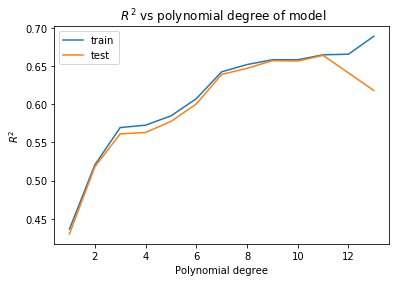

In [41]:
plt.plot(range(1,len(r2_train_list)+1),r2_train_list, label = 'train')
plt.plot(range(1,len(r2_test_list)+1),r2_test_list, label='test')
plt.xlabel("Polynomial degree")
plt.ylabel("$R^2$")
plt.title(" $R^2$ vs polynomial degree of model")
plt.legend();

In [42]:
model_list[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     129.5
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        19:23:44   Log-Likelihood:                -53827.
No. Observations:                8690   AIC:                         1.078e+05
Df Residuals:                    8600   BIC:                         1.085e+05
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -19.1927     36.109     -0.532      0.595     -89.975      51.589
hour              52.9825     22.727      2.331      0.020       8.432      97.533
holiday          -23.7767      8.287     -2.869      0.004     -40.021      -7.533
year              87.1602      2.747     31.726      0.000      81.775      92.546
temp             -19.1048     56.492     -0.338      0.735    -129.843      91.634
hum             -128.6486     56.776     -2.266      0.023    -239.942     -17.355
windspeed          6.1020     11.652      0.524      0.601     -16.739      28.943
Feb               39.3743     32.962      1.195      0.232     -25.239     103.988
Mar               53.8540     33.853      1.591      0.112     -12.506     120.214
Apr              201.2781     40.928      4.918      0.000     121.050     281.507
May              310.0375     56.157      5.521      0.000     199.956     420.119
Jun              237.8578     70.690      3.365      0.001      99.288     376.428
Jul              237.4176    106.486      2.230      0.026      28.680     446.156
Aug              178.2551     95.971      1.857      0.063      -9.871     366.381
Sept             360.4077     60.205      5.986      0.000     242.391     478.424
Oct              297.6535     46.039      6.465      0.000     207.407     387.900
Nov              117.9949     38.726      3.047      0.002      42.083     193.907
Dec               75.7784     34.510      2.196      0.028       8.131     143.426
Mon              -27.6648     25.176     -1.099      0.272     -77.016      21.686
Tue                5.1694     24.825      0.208      0.835     -43.493      53.831
Wed               13.0413     25.469      0.512      0.609     -36.884      62.967
Thu              -47.6338     25.383     -1.877      0.061     -97.390       2.123
Fri               -3.0669     25.649     -0.120      0.905     -53.345      47.212
Sat               41.2801     24.649      1.675      0.094      -7.038      89.598
Cloudy           -15.3687      3.228     -4.761      0.000     -21.696      -9.041
Snow             -70.0735      5.672    -12.354      0.000     -81.192     -58.955
Storm           -121.9856    119.773     -1.018      0.308    -356.768     112.797
temp_2          -263.3262    207.566     -1.269      0.205    -670.206     143.553
temp_3           891.7609    254.318      3.506      0.000     393.237    1390.285
temp_4          -559.9468    104.442     -5.361      0.000    -764.677    -355.216
hum_2            461.8286    204.005      2.264      0.024      61.930     861.727
hum_3           -565.7751    255.998     -2.210      0.027   -1067.592     -63.959
hum_4            229.3932    108.119      2.122      0.034      17.455     441.332
windspeed_2        1.2549     35.335      0.036      0.972     -68.010      70.519
windspeed_3 

In [43]:
model_list[4].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     130.2
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        19:23:44   Log-Likelihood:                -53702.
No. Observations:                8690   AIC:                         1.076e+05
Df Residuals:                    8596   BIC:                         1.083e+05
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -37.8730     35.844     -1.057      0.291    -108.136      32.390
hour            -389.5774     35.982    -10.827      0.000    -460.111    -319.044
holiday          -24.6331      8.184     -3.010      0.003     -40.675      -8.591
year              86.5231      2.710     31.922      0.000      81.210      91.836
temp             -27.1983     96.768     -0.281      0.779    -216.887     162.491
hum               38.5443     90.171      0.427      0.669    -138.212     215.301
windspeed        -12.5038     16.117     -0.776      0.438     -44.097      19.090
Feb               42.9622     32.532      1.321      0.187     -20.808     106.732
Mar               55.0046     33.394      1.647      0.100     -10.456     120.465
Apr              197.7866     40.526      4.880      0.000     118.346     277.228
May              322.9334     55.462      5.823      0.000     214.215     431.652
Jun              290.5209     70.934      4.096      0.000     151.473     429.569
Jul              289.2645    105.525      2.741      0.006      82.410     496.119
Aug              207.4676     96.685      2.146      0.032      17.942     396.993
Sept             381.5874     59.654      6.397      0.000     264.651     498.523
Oct              305.3733     45.618      6.694      0.000     215.950     394.796
Nov              125.7868     38.197      3.293      0.001      50.912     200.661
Dec               89.1530     34.096      2.615      0.009      22.316     155.990
Mon              -23.5691     24.838     -0.949      0.343     -72.257      25.119
Tue                3.7618     24.525      0.153      0.878     -44.312      51.836
Wed               12.1523     25.163      0.483      0.629     -37.173      61.478
Thu              -39.2125     25.109     -1.562      0.118     -88.432      10.007
Fri               -2.4043     25.317     -0.095      0.924     -52.031      47.222
Sat               39.9102     24.327      1.641      0.101      -7.776      87.596
Cloudy           -13.1395      3.189     -4.120      0.000     -19.391      -6.889
Snow             -64.4218      5.617    -11.470      0.000     -75.432     -53.412
Storm           -110.1327    118.105     -0.933      0.351    -341.646     121.381
temp_2          -173.4060    506.674     -0.342      0.732   -1166.608     819.796
temp_3           684.4259   1025.276      0.668      0.504   -1325.360    2694.212
temp_4          -360.3506    927.084     -0.389      0.698   -2177.658    1456.957
temp_5           -60.8929    311.753     -0.195      0.845    -672.003     550.217
hum_2           -578.8289    516.212     -1.121      0.262   -1590.728     433.070
hum_3           1618.9895   1117.673      1.449      0.148    -571.917    3809.896
hum_4          -1725.0533   1054.354     -1.636      0.102   -3791.840     341.734
hum_5       

**4.6 For each degree in 1 through 8...**

**4.7 Discuss patterns you see in the results...**

- The $R^2$ keeps increasing in both the train and test sets up to degree 11. This could be interpreted as low bias high variance, and more complexity in the model helps us. After degree 11, the train and test sets start to differ, so we reached a point where we are overfitting. 
- Up until degree 4, the condition number and the size of the parameters are manageable. After degree 5, the paramaters start growing quite a bit and condition numbers start being indicated as large. 
- Given that our objective is to predict hourly demand of bikes and give suggestions to increase revenue, and we have no signs of overfitting at degree 8, I'd choose degree 8 from the choices in the question. Some parameter shinkage method might help with condition numbers/coefficient sizes but it's not strictly necessary.

---

<div class='exercise'> <b> Question 5 [20pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring degree and regularization combination.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**5.6** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.7** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Answers

**5.1 Let's try regularizing our models via...** 

In [44]:
train_reg, val_reg = train_test_split(BSS_train, test_size=0.2)
train_reg.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,registered,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
1906,18,0,0,1,0.64,0.5758,0.89,0.0000,18,219,...,0,0,0,1,0,0,0,0,1,0
8342,21,0,1,0,0.44,0.4394,0.44,0.2239,22,118,...,0,0,0,0,0,0,1,0,0,0
1892,13,0,0,1,0.30,0.2879,0.24,0.2239,14,69,...,0,1,0,0,0,0,0,1,0,0
16,22,0,0,0,0.64,0.5758,0.83,0.1343,31,97,...,0,0,0,0,0,0,0,0,0,0
868,12,0,1,0,0.84,0.7727,0.47,0.1045,153,336,...,0,0,0,0,0,0,0,0,0,0


In [45]:
lam=[.01,.05,.1,.5,1,5,10,50,100]
lam_df=[]
model_df=[]
for la in lam:
    model_lam, r2_train_lam, r2_test_lam  = eight_models(train_reg, val_reg, bad_columns, model='Ridge', lam=la, maxDeg=8)
    lam_df.append(r2_test_lam)
    model_df.append(model_lam)

In [46]:
lam_df = pd.DataFrame(lam_df,columns=range(1,9),index=[.01,.05,.1,.5,1,5,10,50,100])
lam_df

,1,2,3,4,5,6,7,8
0.01,0.425123,0.510261,0.566586,0.569091,0.577273,0.575976,0.584438,0.601573
0.05,0.425177,0.510267,0.566428,0.569474,0.573822,0.574460,0.574920,0.581523
0.10,0.425238,0.510271,0.566225,0.569632,0.572568,0.573744,0.573519,0.576812
0.50,0.425601,0.510306,0.564665,0.569347,0.571151,0.571973,0.571962,0.572402
1.00,0.425883,0.510395,0.563053,0.568800,0.570748,0.571421,0.571455,0.571640
5.00,0.426707,0.510986,0.555415,0.566093,0.569383,0.570321,0.570400,0.570363
10.00,0.426949,0.511105,0.549840,0.563881,0.568389,0.569736,0.569924,0.569837
50.00,0.426225,0.506861,0.535242,0.554264,0.563482,0.567080,0.568117,0.568164
100.00,0.424908,0.498936,0.528281,0.548032,0.559328,0.564544,0.566418,0.566764


**5.2 Find the best-scoring degree and regularization combination.**

In [47]:
lam_df.idxmax()

1    10.00
2    10.00
3     0.01
4     0.10
5     0.01
6     0.01
7     0.01
8     0.01
dtype: float64

The best $R^2$ is found at degree 8 with $\lambda=0.01$, so highest degree polynomial with minimum shrinkage

**5.3 It's time to see how well our selected model...**


In [48]:
lam=[.01,.05,.1,.5,1,5,10,50,100]
lam_df_test=[]
model_df=[]
for la in lam:
    #Using train_reg, the training set from the 80-20 split, along with BSS_test
    model_lam, r2_train_lam, r2_test_lam,  = eight_models(train_reg, BSS_test, bad_columns, model='Ridge', lam=la, maxDeg=8)
    lam_df_test.append(r2_test_lam)
    model_df.append(model_lam)

In [49]:
lam_df_test = pd.DataFrame(lam_df_test,columns=range(1,9),index=[.01,.05,.1,.5,1,5,10,50,100])
lam_df_test

,1,2,3,4,5,6,7,8
0.01,0.428708,0.517072,0.560779,0.562550,0.573807,0.573295,0.581074,0.599033
0.05,0.428750,0.517099,0.560815,0.562667,0.567857,0.569868,0.570169,0.576239
0.10,0.428798,0.517124,0.560838,0.562664,0.565977,0.568205,0.568137,0.570858
0.50,0.429053,0.517203,0.560629,0.562416,0.563896,0.565083,0.565349,0.565585
1.00,0.429217,0.517233,0.560071,0.562232,0.563452,0.564307,0.564577,0.564682
5.00,0.429445,0.517209,0.555437,0.561298,0.562650,0.563139,0.563276,0.563322
10.00,0.429304,0.516835,0.551035,0.560187,0.562215,0.562711,0.562767,0.562743
50.00,0.427610,0.510828,0.537716,0.553050,0.559111,0.560840,0.561000,0.560741
100.00,0.425876,0.501733,0.530473,0.547368,0.555631,0.558687,0.559318,0.559070


In [50]:
lam_df_test.idxmax()

1    5.00
2    1.00
3    0.10
4    0.05
5    0.01
6    0.01
7    0.01
8    0.01
dtype: float64

- The best model in the test set remains degree 8 with $\lambda=0.01$. The $R^2$ in this both validation and test sets were very similar, around 0.6. This could be for different factors, we could have gotten a higher or lower $R^2$ in the test set, but the important part is that the same model performs the best in the validation and test sets. 
- For lower degree polynomials, up to 4, some shrinkage helps. For degree one, $\lambda = 1.00$ is the best choice. I believe this is because shrinking the coefficients helps with multicollinearity problems, like the ones we saw in past exercises.

**5.4 Build a dataset with polynomial degree 1...**

In [51]:
model_cv_ols, r2_train_cv_ols, r2_test_cv_ols = eight_models(train_reg,BSS_test, bad_columns, model='OLS', lam=la, maxDeg=1)
print(" The R^2 for OLS on the test set is {}".format(r2_test_cv_ols))

 The R^2 for OLS on the test set is [0.42869717507980487]


In [52]:
model_cv_ridge, r2_train_cv_ridge, r2_test_cv_ridge = eight_models(train_reg, 
                                                                   BSS_test, bad_columns, model='RidgeCV', lam=la, maxDeg=1)


print(" The R^2 for the best Ridge model on the test set is {} with lambda {}".format(
                                                                               r2_test_cv_ridge, model_cv_ridge[0].alpha_))

 The R^2 for the best Ridge model on the test set is [0.4292166270431317] with lambda 1.0


In [53]:
model_cv_lasso, r2_train_cv_lasso, r2_test_cv_lasso,  = eight_models(train_reg, 
                                                                   BSS_test, bad_columns, model='LassoCV', lam=la, maxDeg=1)
print(" The R^2 for the best Lasso model on the test set is {} with lambda {}".format(
                                                                               r2_test_cv_lasso, model_cv_lasso[0].alpha_))

 The R^2 for the best Lasso model on the test set is [0.42929260993099205] with lambda 0.05


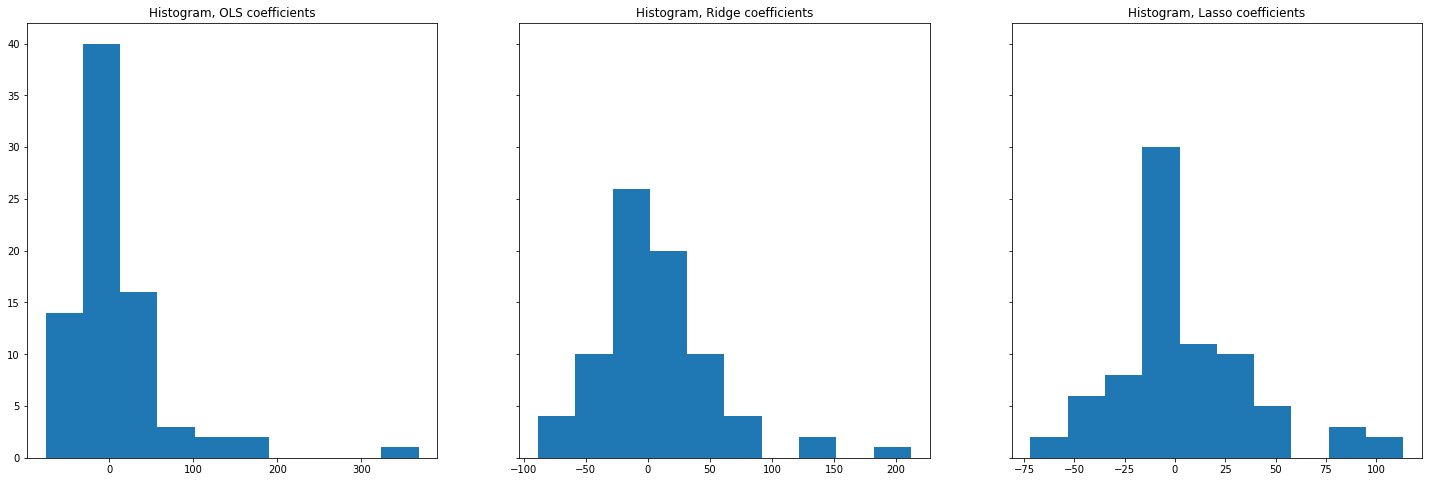

In [54]:
fig,ax = plt.subplots(1,3, sharey=True,figsize=(25,8))
ax[0].hist(model_cv_ols[0].params)
ax[0].set_title("Histogram, OLS coefficients")
ax[1].hist(model_cv_ridge[0].coef_, )
ax[1].set_title("Histogram, Ridge coefficients")
ax[2].hist(model_cv_lasso[0].coef_)
ax[2].set_title("Histogram, Lasso coefficients");

**5.5 Plot histograms of the coefficients found...**

- Both ridge and lasso shrink the coefficients
- The Ridge histogram looks like a bell shaped curve centered close to 0, which makes sense since it comes from a normal prior centered at 0.
- The Lasso histogram looks like a bell but with a much more pronounced peak as 0, which makes sense since it comes from a Laplace prior centered at 0, and its shrinking some coefficients to 0

**5.6 The plots above show the overall distribution of... **

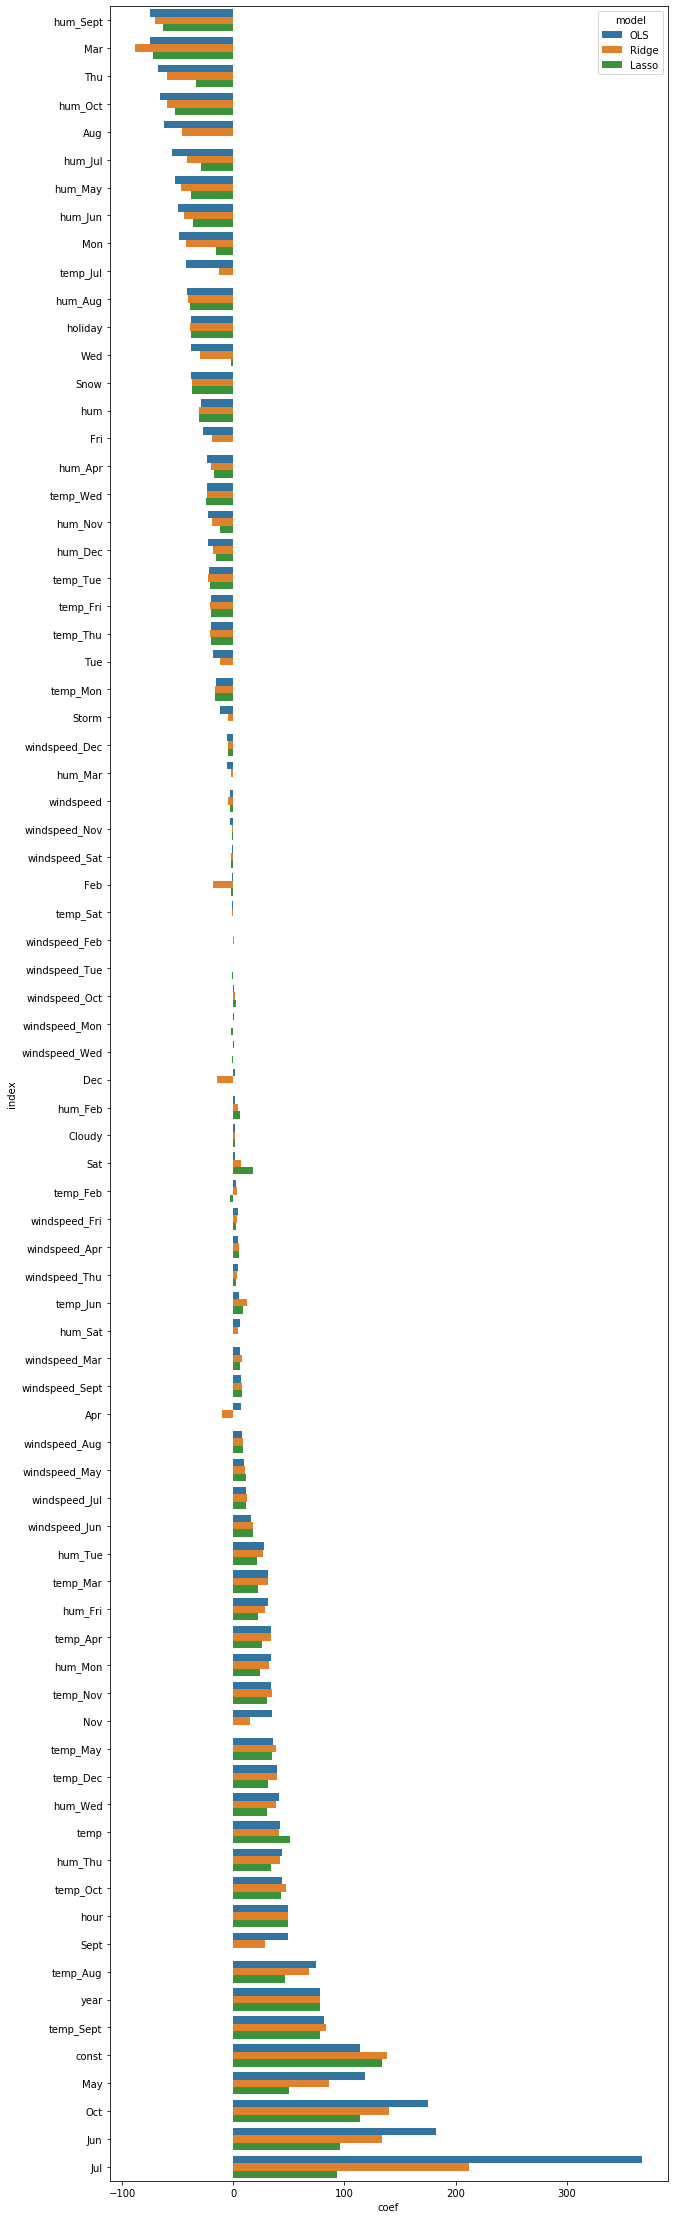

In [55]:
ridge_coef = np.array([model_cv_ridge[0].intercept_] + list(model_cv_ridge[0].coef_))
lasso_coef = np.array([model_cv_lasso[0].intercept_] + list(model_cv_lasso[0].coef_))
param_names = model_cv_ols[0].params.index
sorted_index = model_cv_ols[0].params.reset_index()[0].sort_values(ascending=True).index

f, ax = plt.subplots(figsize=(10, 40))
ind = model_cv_ols[0].params[sorted_index].index
bar=pd.DataFrame()
bar = bar.append(pd.DataFrame({'coef':model_cv_ols[0].params[sorted_index],'model':'OLS'}))
bar = bar.append(pd.DataFrame({'coef':ridge_coef[sorted_index] ,'model':'Ridge'},index = ind ))
bar = bar.append(pd.DataFrame({'coef':lasso_coef[sorted_index] ,'model':'Lasso'},index = ind ))
bar = bar.reset_index()
p = sns.barplot(data=bar,x='coef',y='index',hue='model')


**5.7 What trends do you see...**

- Except for the coefficients close to 0, most coefficients keep their sign
- Both Lasso and Ridge shrink their coefficients. Lasso seems to do it more than Ridge on large positive coefficients
- Many green bars aren't there for some features as Lasso selects features
- Temp doesn't change too much across models. It even increases slightly for Lasso.

*your answer here*

---

<div class='exercise'> <b> Question 6 [16 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**6.1** Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

**6.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

**6.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

**6.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?


### Answers

**6.1 Reflect back on the get_design_mats function you built...**

The get_design_mats function was very useful. Once it was implemented, I didn't need to worry about adding polynomial or cross terms. It was general enough to be useful for all the exercises that came after. It fit perfectly well in the eight_models function. Better options depend on how you structured the rest of the problems. For me, it worked really well and I wouldn't change it.

**6.2 What are the costs and benefits of applying ridge/lasso...**

Costs: 
- Regularization methods trade variance for bias. You reduce variance by reducing model flexibility, in exchange for having your coefficient estimates be biased. This is particularly true for Ridge.
- You also lose the ability to interpret some coefficients (more on Ridge, which doesn't select features), and you require a numerical optimization procedure as opposed to analytical solutions for OLS.
- Lasso selects features, and there are situations where you might not want that.
- Ridge uses L-2 norm penalty, which has better continuity/differentiable properties than L-1

Benefits: 
- When OLS estimates have high variance, the bias-variance trade-off pays dividends, specially in Ridge.
- Lasso selects features, which can be very useful finding model subsets.
- Forward selecting polynomial features can be expensive, as you might need to look under all possible subsets of possible coefficients. Lasso doesn't have this problem.
- Ridge does a good job reducing collinearity and variance inflation factors for parameters.
- Higher degree polynomials will have wildly varying coefficients as they try to fit the data. Multicollinearity will be an issue, even with scaled data.


**6.3 This pset posed a purely predictive goal: forecast ridership...**

Since our goal is only predictive, interpretability of the coefficients wouldn't be the primary issue. We want our model to be as accurate as possible, and we understand the reasons the coefficients become hard to interpret (multicollinearity and shrinkage, for example). 

**6.4 Reflect back on our original goal of helping BikeShare predict...**

I think we did a decent job on our original goal, given the fact the only tool we have is OLS. We have an understanding of seasonality patters, both intraday, by month, by season... We have a concept of the differences between casual and registered demand, as well as differences in demand depending on the weather. 

The best model we found (8 degree polynomial non-regularized) has an $R^2$ of around 0.60, and was the best in validation and test. We can be use it for point and interval estimates. 

Since the most complex and least regularized model was the best, I think there would be room to find a more sophisticated/complex model that could do a better job predicting forecast ridership.